# This file includes implementation of both methods used in our paper:
## 1- First method we introduce the HybridCNN+MLP method, this method is adopted in previous works of the lab that had made the dataset (SUSU dataset).
## 2- Second method we introduce is the LPC-NN method, this method is consdered as an enhancment for the existing work.

# HybridCNN+MLP

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import glob
import PIL
import imageio
import seaborn as sn
import matplotlib.pyplot as plt

from numpy import savez_compressed
from PIL import Image
from scipy import misc

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report

from tensorflow.keras.layers import concatenate
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

from IPython.display import HTML, display

## Functions

In [2]:
def results(history, model, testX, testY):
  plt.rc('axes',edgecolor='k')
  plt.rc('axes',linewidth='1')
  plt.rcParams['figure.dpi'] = 100
  dataset_labels=np.array(['Normal','Inner', 'Outer', 'Ball', 'Comb'])
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(len(history.history['loss']))
  plt.figure(figsize=(8, 5))
  plt.subplot(121, facecolor='w')
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(122, facecolor='w')
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()
  

  test_loss, test_acc = model.evaluate(testX, testY, verbose=2)

  # Confusion Matrix
  predictions = model.predict(testX)
  confusion = confusion_matrix(np.argmax(testY, axis=1), 
                              np.argmax(predictions, axis=1))
  print('CONFUSION MATRIX\n', confusion, '\n\n')
  # normalize confustion matrix [0 1]
  # confusion = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]
  df_cm = pd.DataFrame(confusion, 
                       dataset_labels, 
                       dataset_labels)
  sn.set(font_scale=1.2) # for label size
  plt.figure(figsize=(4,4))
  sn.heatmap(df_cm, 
             annot=True, 
             annot_kws={"size": 10},
             fmt = "d",
             linewidths=.5,
             cmap="YlGnBu") 
  plt.title(str(model.name))
  plt.ylabel("True Label")
  plt.xlabel("Predicted Label")
  plt.show()

  print('CLASSIFICATION REPORT\n',
        classification_report(np.argmax(testY, axis=1), 
                              np.argmax(predictions, axis=1), 
                              target_names=dataset_labels))

In [3]:
def progress(value, max=100):
  # Progress Bar
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 50%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

In [4]:
def load_signals_attributes(input_path, display=False):
  print('[INFO] Loading…\n')
  cols = ["N1", "N2", "class"]
  df = pd.read_csv(input_path, sep=" ", header=None, names=cols)
  print('[INFO] Attributes loaded successfully!\n')
  if display == True:
    df.head()
  return df

In [5]:
def load_signals_images(input_path):
  print(os.listdir(input_path))
  print('[INFO] Sorting files in directory...\n')
  path = input_path+"/*.png"
  directory = sorted(glob.glob(path), key=len) 
  directory = sorted(glob.glob(path), 
                    key=lambda x: int(os.path.basename(x).split('.')[0]))

  def get_key(fp):
      filename = os.path.splitext(os.path.basename(fp))[0]
      int_part = filename.split()[0]
      return int(int_part)
  directory = sorted(glob.glob(path), 
                    key=get_key)

  print('[INFO] Loading images in matrices...\n')
  Im = []
  bar = display(progress(0, len(directory)), display_id=True) # Progress Bar
  counter = 0
  for image_path in directory:
    img = imageio.imread(image_path)
    Im.append(img)
    counter += 1
    bar.update(progress(counter, len(directory))) # Update Progress
  # Масштабируем  
  Im = np.array(Im)/255.0
  print("[INFO] Dataset loaded")
  return Im

## Load dataset

## Main Data

In [6]:
data_root_Train='G:\\SUSU\\LPC\Code\\Datasets\\imagesTrain'
data_root_Test='G:\\SUSU\\LPC\Code\\Datasets\\imagesTest'


In [7]:
attr_Train = load_signals_attributes(data_root_Train+"/TxtInfo_Train.txt")
attr_Test = load_signals_attributes(data_root_Test+"/TxtInfo_Test.txt")

[INFO] Loading…

[INFO] Attributes loaded successfully!

[INFO] Loading…

[INFO] Attributes loaded successfully!



In [8]:
images_Train = load_signals_images(data_root_Train) # сырые картинки, которые будут нормализованы (нужно больше времени)
images_Test = load_signals_images(data_root_Test);

['1.png', '10.png', '100.png', '1000.png', '1001.png', '1002.png', '1003.png', '1004.png', '1005.png', '1006.png', '1007.png', '1008.png', '1009.png', '101.png', '1010.png', '1011.png', '1012.png', '1013.png', '1014.png', '1015.png', '1016.png', '1017.png', '1018.png', '1019.png', '102.png', '1020.png', '1021.png', '1022.png', '1023.png', '1024.png', '1025.png', '1026.png', '1027.png', '1028.png', '1029.png', '103.png', '1030.png', '1031.png', '1032.png', '1033.png', '1034.png', '1035.png', '1036.png', '1037.png', '1038.png', '1039.png', '104.png', '1040.png', '1041.png', '1042.png', '1043.png', '1044.png', '1045.png', '1046.png', '1047.png', '1048.png', '1049.png', '105.png', '1050.png', '1051.png', '1052.png', '1053.png', '1054.png', '1055.png', '1056.png', '1057.png', '1058.png', '1059.png', '106.png', '1060.png', '1061.png', '1062.png', '1063.png', '1064.png', '1065.png', '1066.png', '1067.png', '1068.png', '1069.png', '107.png', '1070.png', '1071.png', '1072.png', '1073.png', '107

[INFO] Dataset loaded
['1.png', '10.png', '100.png', '101.png', '102.png', '103.png', '104.png', '105.png', '106.png', '107.png', '108.png', '109.png', '11.png', '110.png', '111.png', '112.png', '113.png', '114.png', '115.png', '116.png', '117.png', '118.png', '119.png', '12.png', '120.png', '121.png', '122.png', '123.png', '124.png', '125.png', '126.png', '127.png', '128.png', '129.png', '13.png', '130.png', '131.png', '132.png', '133.png', '134.png', '135.png', '136.png', '137.png', '138.png', '139.png', '14.png', '140.png', '141.png', '142.png', '143.png', '144.png', '145.png', '146.png', '147.png', '148.png', '149.png', '15.png', '150.png', '151.png', '152.png', '153.png', '154.png', '155.png', '156.png', '157.png', '158.png', '159.png', '16.png', '160.png', '161.png', '162.png', '163.png', '164.png', '165.png', '166.png', '167.png', '168.png', '169.png', '17.png', '170.png', '171.png', '172.png', '173.png', '174.png', '175.png', '176.png', '177.png', '178.png', '179.png', '18.png'

[INFO] Dataset loaded


## Split

In [9]:

testAttrX=attr_Test
testImagesX=images_Test

AttrX=attr_Train
ImagesX=images_Train

split = train_test_split(AttrX, ImagesX, test_size=0.1, random_state=42)
(trainAttrX,validAttrX, trainImagesX, validImagesX) = split

trainAttrX

continuous = ["N1", "N2"]

# Normalizing data to be the interval [0 1]
cs = MinMaxScaler()
trainAttrXnorm = cs.fit_transform(trainAttrX[continuous])
validAttrXnorm = cs.fit_transform(validAttrX[continuous])
testAttrXnorm = cs.transform(testAttrX[continuous])

zipBinarizer = LabelBinarizer().fit(attr_Train["class"])
trainY = zipBinarizer.transform(trainAttrX["class"])
validY = zipBinarizer.transform(validAttrX["class"])

zipBinarizer = LabelBinarizer().fit(attr_Test["class"])
testY = zipBinarizer.transform(testAttrX["class"])

print(trainAttrX.shape)
print(validAttrX.shape)
print(testAttrX.shape)
print(trainImagesX.shape)
print(validImagesX.shape)
print(testImagesX.shape)



(1939, 3)
(216, 3)
(920, 3)
(1939, 32, 32, 3)
(216, 32, 32, 3)
(920, 32, 32, 3)


In [10]:
def create_mlp(dim, regress=False):
	model = Sequential()
	model.add(Dense(16, input_dim=dim, activation="relu"))
	model.add(Dense(8, activation="relu"))

	if regress:
		model.add(Dense(5))

	return model

In [11]:
def create_cnn(width, height, depth, filters=(16, 32, 64), regress=False):
	# initialize the input shape and channel dimension, assuming
	# TensorFlow/channels-last ordering
	inputShape = (height, width, depth)
	chanDim = -1

	# define the model input
	inputs = Input(shape=inputShape)

	# loop over the number of filters
	for (i, f) in enumerate(filters):
		# if this is the first CONV layer then set the input
		# appropriately
		if i == 0:
			x = inputs

		# CONV => RELU => BN => POOL
		x = Conv2D(f, (3, 3), padding="same")(x)
		x = Activation("relu")(x)
		x = BatchNormalization(axis=chanDim)(x)
		x = MaxPooling2D(pool_size=(2, 2))(x)
    

	# flatten the volume, then FC => RELU => BN => DROPOUT
	x = Flatten()(x)
	x = Dense(16)(x)
	x = Activation("relu")(x)
	x = BatchNormalization(axis=chanDim)(x)
	x = Dropout(0.5)(x) 

	# apply another FC layer, this one to match the number of nodes
	# coming out of the MLP
	x = Dense(8)(x)
	x = Activation("relu")(x)

	# check to see if the regression node should be added
	if regress:
		x = Dense(5)(x)

	# construct the CNN
	model = Model(inputs, x)

	# return the CNN
	return model  

## Hybrid CNN + MLP

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
print('[INFO] Creating Hybrid CNN+MLP...')
mlp = create_mlp(trainAttrXnorm.shape[1], regress=False)
cnn = create_cnn(32, 32, 3, regress=False) 

combinedInput = concatenate([mlp.output, cnn.output])

x = Dense(8, activation="relu")(combinedInput)
x = Dense(5)(x)

checkpoint_path='hybrid1.h5'

keras_callbacks   = [
      EarlyStopping(monitor='val_accuracy', patience=50, verbose=1),
      ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True)
]

model_mixed = Model(inputs=[mlp.input, cnn.input], 
                    outputs=x, 
                    name="Hybrid_CNN_MLP")

print('[INFO] Compiling model...')
opt = tf.keras.optimizers.Adam(learning_rate=1e-4, decay=1e-3 / 200)
model_mixed.compile(optimizer=opt,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

print(model_mixed.summary())


[INFO] Creating Hybrid CNN+MLP...
[INFO] Compiling model...
Model: "Hybrid_CNN_MLP"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 16)   448         ['input_1[0][0]']                
                                                                                                  
 activation (Activation)        (None, 32, 32, 16)   0           ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 16)  64          ['activation[0][0]']             
 alization)              

In [13]:
# train the model
print("[INFO] Training model...")
import timeit

start = timeit.default_timer()

history_model_mixed = model_mixed.fit(
              x=[trainAttrXnorm, trainImagesX], y=trainY,
              validation_data=([validAttrXnorm, validImagesX], validY), 
              batch_size = 20,
              epochs=150,
              callbacks=[keras_callbacks]
)

stop = timeit.default_timer()



[INFO] Training model...
Epoch 1/150
97/97 [==============================] - 2s 16ms/step - loss: 1.6197 - accuracy: 0.3203 - val_loss: 1.6698 - val_accuracy: 0.2130
Epoch 2/150
97/97 [==============================] - 1s 14ms/step - loss: 1.3933 - accuracy: 0.4136 - val_loss: 1.7715 - val_accuracy: 0.2130
Epoch 3/150
97/97 [==============================] - 1s 15ms/step - loss: 1.2660 - accuracy: 0.4709 - val_loss: 1.7304 - val_accuracy: 0.2454
Epoch 4/150
97/97 [==============================] - 1s 15ms/step - loss: 1.1703 - accuracy: 0.5348 - val_loss: 1.3127 - val_accuracy: 0.3889
Epoch 5/150
97/97 [==============================] - 1s 15ms/step - loss: 1.1170 - accuracy: 0.5761 - val_loss: 1.0903 - val_accuracy: 0.5972
Epoch 6/150
97/97 [==============================] - 1s 15ms/step - loss: 1.0620 - accuracy: 0.6091 - val_loss: 0.9667 - val_accuracy: 0.7176
Epoch 7/150
97/97 [==============================] - 1s 15ms/step - loss: 1.0073 - accuracy: 0.6730 - val_loss: 0.8801 - va

## Results

In [14]:
print('Time for training: ', stop - start) 

Time for training:  138.5321935


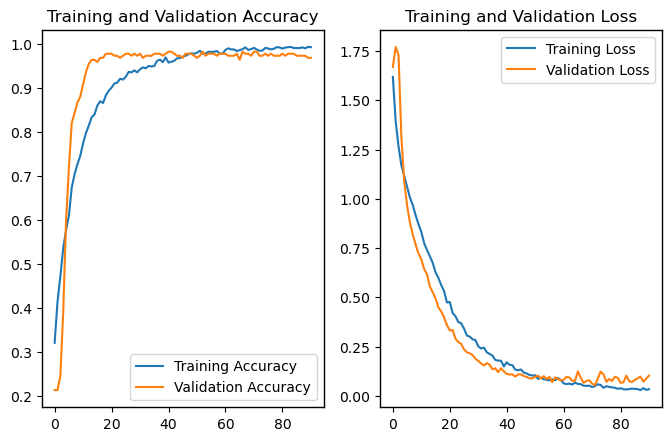

29/29 - 0s - loss: 0.1902 - accuracy: 0.9630 - 315ms/epoch - 11ms/step
CONFUSION MATRIX
 [[180   0   0   4   0]
 [  0 175   0   9   0]
 [  0   1 182   0   1]
 [  1   3   1 179   0]
 [  1   6   4   3 170]] 




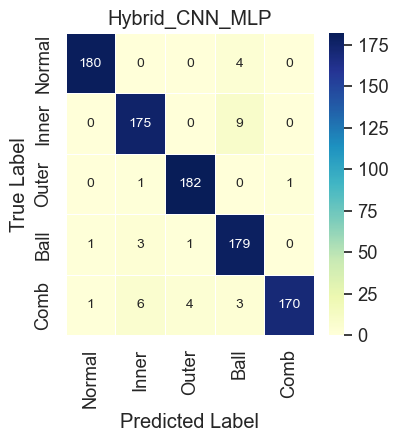

CLASSIFICATION REPORT
               precision    recall  f1-score   support

      Normal       0.99      0.98      0.98       184
       Inner       0.95      0.95      0.95       184
       Outer       0.97      0.99      0.98       184
        Ball       0.92      0.97      0.94       184
        Comb       0.99      0.92      0.96       184

    accuracy                           0.96       920
   macro avg       0.96      0.96      0.96       920
weighted avg       0.96      0.96      0.96       920



In [15]:
from tensorflow.keras.models import load_model
best_model_mixed = load_model(checkpoint_path)


results(history_model_mixed, 
        best_model_mixed, 
        [testAttrXnorm, testImagesX], 
        testY)

### End of HybridCNN+MLP

# LPC-NN

## Loading Data

In [16]:
root_folder_="G:/SUSU/LPC/Code/Datasets/CSV/";

In [17]:
from sklearn.utils import shuffle
# Path to train
path_to_train=root_folder_+"Z_0_TRAIN_70_STEP_2500_OVERLAP_50_PERCERNT_LPC_50_.csv"


#Loading training data
data = pd.read_csv(path_to_train,header=None)
data = data.iloc[np.random.permutation(len(data))]
labels=data.iloc[:,51]
features = data.iloc[:,1:51]
X=features
y=np.ravel(labels)
X_train, y_train = shuffle(X, y)
print(X_train.shape)

(2155, 50)


In [18]:
# Path to test
path_to_test=root_folder_+"Z_0_TEST_70_STEP_2500_OVERLAP_50_PERCERNT_LPC_50_.csv"

#Loading testing data
data12 = pd.read_csv(path_to_test,header=None)
labels12=data12.iloc[:,51]
features12 = data12.iloc[:,1:51]
X12=features12
y12=np.ravel(labels12)
X_test=X12;
y_test=y12;



In [19]:
myN=5; #number of classes

from keras.utils import np_utils
y_train=y_train-1;
y_test=y_test-1;
# Convert to categorical
Y_train = np_utils.to_categorical(y_train, myN) 
Y_test = np_utils.to_categorical(y_test, myN)
Y_test.shape

(920, 5)

In [20]:
model_name='bestmodel_0_0_LPC_NN'
confusion_title="Confusion matrix of SUSU dataset"

## Building model

In [21]:
# Number of classes
myN=5;


# Buidling neural network model
def build_my_model(numberOfClasses):
    model = Sequential()
    model.add(Dense(50, input_dim=50, activation="tanh"))
    model.add(Dense(numberOfClasses))
    #model.add(Dense(numberOfClasses, activation="softmax"))
    #model.compile(loss="categorical_crossentropy",optimizer='adam', metrics=["accuracy"]) 
    opt = tf.keras.optimizers.Adam(learning_rate=1e-4, decay=1e-3 / 200)
    model.compile(optimizer=opt,
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    print(model.summary())
    return model;

In [22]:
checkpoint_path='model_name'
keras_callbacks   = [
    EarlyStopping(monitor='val_accuracy', patience=50, verbose=1),
    ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True)
]

model=build_my_model(myN);

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 50)                2550      
                                                                 
 dense_7 (Dense)             (None, 5)                 255       
                                                                 
Total params: 2,805
Trainable params: 2,805
Non-trainable params: 0
_________________________________________________________________
None


## Training model

In [23]:
import timeit

start = timeit.default_timer()

history=model.fit(X_train, Y_train,epochs=150, batch_size=27, verbose=1, validation_split=0.1,callbacks=[keras_callbacks])
best_model = load_model(checkpoint_path)
model=best_model;

stop = timeit.default_timer()

Epoch 1/150
72/72 [==============================] - 1s 17ms/step - loss: 1.5669 - accuracy: 0.2006 - val_loss: 1.5496 - val_accuracy: 0.1944
Epoch 2/150
72/72 [==============================] - 2s 23ms/step - loss: 1.5170 - accuracy: 0.2316 - val_loss: 1.5025 - val_accuracy: 0.3056
Epoch 3/150
72/72 [==============================] - 0s 6ms/step - loss: 1.4749 - accuracy: 0.4275 - val_loss: 1.4605 - val_accuracy: 0.5185
Epoch 4/150
72/72 [==============================] - 1s 18ms/step - loss: 1.4357 - accuracy: 0.5493 - val_loss: 1.4200 - val_accuracy: 0.5833
Epoch 5/150
72/72 [==============================] - 2s 28ms/step - loss: 1.3973 - accuracy: 0.6101 - val_loss: 1.3795 - val_accuracy: 0.6528
Epoch 6/150
72/72 [==============================] - 2s 26ms/step - loss: 1.3587 - accuracy: 0.6859 - val_loss: 1.3393 - val_accuracy: 0.6898
Epoch 7/150
72/72 [==============================] - 0s 6ms/step - loss: 1.3199 - accuracy: 0.7287 - val_loss: 1.2990 - val_accuracy: 0.7176
Epoch 8/

## Results

In [24]:
print('Time for training: ', stop - start)

Time for training:  24.309182899999996


In [25]:
scores = model.evaluate(X_test, Y_test, verbose=2) 
print(scores)

29/29 - 0s - loss: 0.5462 - accuracy: 1.0000 - 98ms/epoch - 3ms/step
[0.5462067127227783, 1.0]


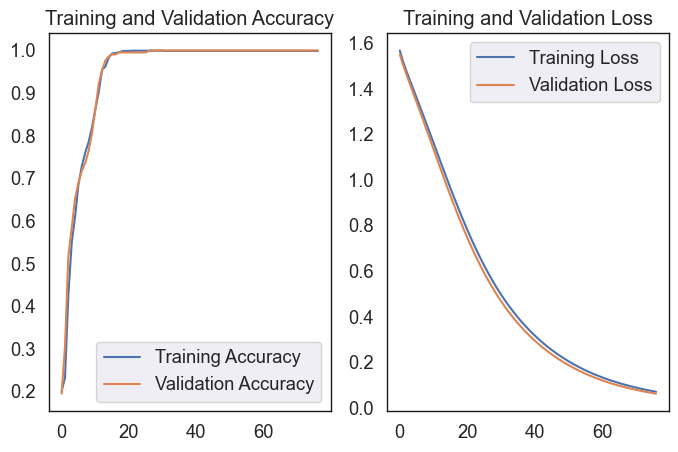

CLASSIFICATION REPORT
               precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       184
       Inner       1.00      1.00      1.00       184
       Outer       1.00      1.00      1.00       184
        Ball       1.00      1.00      1.00       184
        Comb       1.00      1.00      1.00       184

    accuracy                           1.00       920
   macro avg       1.00      1.00      1.00       920
weighted avg       1.00      1.00      1.00       920



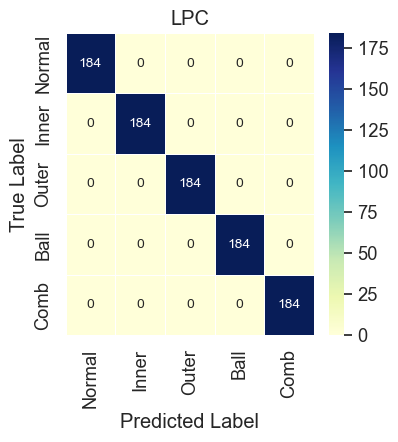

In [26]:
# Plot Training and Validation Accuracy and  Training and Validation Loss
plt.rc('axes',edgecolor='k')
plt.rc('axes',linewidth='1')


plt.rcParams['figure.dpi'] = 100
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(8, 5))
plt.subplot(121, facecolor='w')
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid(b=None)

plt.subplot(122, facecolor='w')
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.grid(b=None)
plt.show()

# Draw confusion matrix (It is only for the last trial)
predictions=model.predict(X_test);
confusion=confusion_matrix(np.argmax(Y_test,axis=1),np.argmax(predictions,axis=1));

dataset_labels=np.array(['Normal','Inner','Outer','Ball','Comb'])
##
df_cm = pd.DataFrame(confusion, 
              dataset_labels, 
              dataset_labels)

sn.set(font_scale=1.2) # for label size
plt.figure(figsize=(4,4))
sn.heatmap(df_cm,annot=True,annot_kws={"size": 10},fmt = "d",linewidths=.5,cmap="YlGnBu") 
plt.title('LPC')
plt.ylabel("True Label")
plt.xlabel("Predicted Label")

# Print classification report
print('CLASSIFICATION REPORT\n',
  classification_report(np.argmax(Y_test, axis=1), 
                        np.argmax(predictions, axis=1), 
                        target_names=dataset_labels))

